### Contents:

- Covid-19 global data analysis.
- Comparing trajectories of deaths, confirmed and active cases for different countries.
- Time Series forecasting: Using ARIMA model to predict deaths in US and India for next 15 days.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import csv
import itertools
from collections import defaultdict
import datetime as dt
import re
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics

%matplotlib inline

In [376]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 50)
plt.rcParams["figure.figsize"] = [10, 10]
sns.set_style('darkgrid')

In [3]:
base_dir = '../data/Global/csse_covid_19_daily_reports/'

In [4]:
abs_path = os.path.abspath(base_dir)

In [5]:
files = os.listdir(abs_path)
csv_files = filter(lambda file: '.csv' in file, files)
csv_abs_path = [os.path.join(abs_path, csv_file) for csv_file in csv_files]

In [6]:
csv_abs_path = sorted(csv_abs_path)

In [8]:
covid_list_6_columns = []
covid_list_8_columns = []
covid_list_12_columns = []
covid_list_14_columns = []
d = defaultdict()
for file in csv_abs_path:
    with open(file, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader) 
        l = [i for i in reader]
        size = len(l[0])
        d[size] = size + 1
    if size == 6:
        covid_list_6_columns.extend(l)
    elif size == 8:
        covid_list_8_columns.extend(l)
    elif size == 12:
        covid_list_12_columns.extend(l)
    elif size == 14:
        covid_list_14_columns.extend(l)

### Columns:

- df6: Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
- df8: Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
- df12: 'FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key'
- df14: 'FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'


### Create DataFrame

In [9]:
df6 = pd.DataFrame(covid_list_6_columns, columns=['Province/State','Country/Region','Last Update','Confirmed','Deaths','Recovered'])
df8 = pd.DataFrame(covid_list_8_columns, columns=['Province/State','Country/Region','Last Update','Confirmed','Deaths','Recovered','Latitude','Longitude'])
df12 = pd.DataFrame(covid_list_12_columns, columns=['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key'])
df14 = pd.DataFrame(covid_list_14_columns, columns=['FIPS','Admin2','Province_State','Country_Region','Last_Update','Lat','Long_','Confirmed','Deaths','Recovered','Active','Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'])

In [10]:
df6.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1/22/2020 17:00,1,,
1,Beijing,Mainland China,1/22/2020 17:00,14,,
2,Chongqing,Mainland China,1/22/2020 17:00,6,,
3,Fujian,Mainland China,1/22/2020 17:00,1,,
4,Gansu,Mainland China,1/22/2020 17:00,,,


In [11]:
df8.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,Mainland China,2020-03-01T10:13:19,66907,2761,31536,30.9756,112.2707
1,,South Korea,2020-03-01T23:43:03,3736,17,30,36.0000,128.0000
2,,Italy,2020-03-01T23:23:02,1694,34,83,43.0000,12.0000
3,Guangdong,Mainland China,2020-03-01T14:13:18,1349,7,1016,23.3417,113.4244
4,Henan,Mainland China,2020-03-01T14:13:18,1272,22,1198,33.8820,113.6140


In [12]:
df12.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061,New York City,New York,US,3/22/20 23:45,40.7672726,-73.97152637,9654,63,0,0,"New York City, New York, US"
1,36059,Nassau,New York,US,3/22/20 23:45,40.74066522,-73.58941873,1900,4,0,0,"Nassau, New York, US"
2,36119,Westchester,New York,US,3/22/20 23:45,41.16278376,-73.75741653,1873,0,0,0,"Westchester, New York, US"
3,36103,Suffolk,New York,US,3/22/20 23:45,40.88320119,-72.8012172,1034,9,0,0,"Suffolk, New York, US"
4,36087,Rockland,New York,US,3/22/20 23:45,41.15027894,-74.02560498,455,1,0,0,"Rockland, New York, US"


In [13]:
df14.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001,Abbeville,South Carolina,US,2020-05-30 02:32:48,34.22333378,-82.46170658,39,0,0,39,"Abbeville, South Carolina, US",159.0084396787214,0.0
1,22001,Acadia,Louisiana,US,2020-05-30 02:32:48,30.2950649,-92.41419698,401,23,0,378,"Acadia, Louisiana, US",646.305101136272,5.7356608478802995
2,51001,Accomack,Virginia,US,2020-05-30 02:32:48,37.76707161,-75.63234615,827,12,0,815,"Accomack, Virginia, US",2559.1038494863224,1.4510278113663846
3,16001,Ada,Idaho,US,2020-05-30 02:32:48,43.4526575,-116.24155159999998,803,22,0,781,"Ada, Idaho, US",166.7403812810562,2.73972602739726
4,19001,Adair,Iowa,US,2020-05-30 02:32:48,41.33075609,-94.47105874,9,0,0,9,"Adair, Iowa, US",125.83892617449665,0.0


In [14]:
df6['Last Update'].dtype

dtype('O')

In [15]:
len(df6)

2818

In [16]:
len(df12)

214844

In [17]:
len(df12) + len(df8) + len(df6)

222461

### Merge 3 DataFrames

In [18]:
df1 = pd.concat([df6, df8, df12, df14], axis=0, sort=False)

In [19]:
df1.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,Anhui,Mainland China,1/22/2020 17:00,1,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Beijing,Mainland China,1/22/2020 17:00,14,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Chongqing,Mainland China,1/22/2020 17:00,6,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fujian,Mainland China,1/22/2020 17:00,1,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gansu,Mainland China,1/22/2020 17:00,,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

In [20]:
df1['Country/Region'] = df1['Country/Region'].fillna('')
df1['Country_Region'] = df1['Country_Region'].fillna('')
df1['Country_Region'] = df1['Country_Region'] + df1['Country/Region']

In [21]:
df1 = df1.drop(columns='Country/Region')

In [22]:
df1['Last Update'] = df1['Last Update'].fillna('')
df1['Last_Update'] = df1['Last_Update'].fillna('')
df1['Last_Update'] = df1['Last_Update'] + df1['Last Update']
df1 = df1.drop(columns=['Last Update'])

In [23]:
df1['Province/State'] = df1['Province/State'].fillna('')
df1['Province_State'] = df1['Province_State'].fillna('')
df1['Province_State'] = df1['Province_State'] + df1['Province/State']
df1 = df1.drop(columns=['Province/State'])

#### Uniform Datetime format

- DataFrame has 4-5 different datetime formats.
- When pd.to_datetime is used, majority of the dates become NAT, because it is not able to infer them.
- The problem is solved using dateutil package.

In [24]:
import dateutil.parser
date = dateutil.parser.parse("1/23/20 17:00").strftime("%m/%d/%Y, %H:%M:%S")
date

'01/23/2020, 17:00:00'

In [25]:
df1['Last_Update'] = df1['Last_Update'].apply(lambda x: dateutil.parser.parse(x).strftime("%Y-%m-%d %H:%M:%S"))

In [26]:
df1['Last_Update'] = pd.to_datetime(df1['Last_Update'], infer_datetime_format=True, errors='coerce')

In [27]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
Latitude               324913
Longitude              324913
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                   7617
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
dtype: int64

#### Only 4799 rows have latitude and longitude values out of 201896 rows, that is 2%, thus removing those columns. 

In [28]:
df1 = df1.drop(columns=['Latitude', 'Longitude'])

In [29]:
df1.isna().sum()

Confirmed                   0
Deaths                      0
Recovered                   0
FIPS                     7617
Admin2                   7617
Province_State              0
Country_Region              0
Last_Update                 0
Lat                      7617
Long_                    7617
Active                   7617
Combined_Key             7617
Incidence_Rate         222461
Case-Fatality_Ratio    222461
dtype: int64

In [30]:
df1['date'] = pd.to_datetime(df1['Last_Update']).dt.date

In [31]:
df1.loc[df1['Country_Region'].isin(['Mainland China', 'China']), 'Country_Region'] = 'China'

In [32]:
df1.Deaths.unique()

array(['', '17', '1', ..., '1224', '2340', '5065'], dtype=object)

### Check and update datatypes if not correct

In [33]:
df1.loc[df1['Deaths'] == '', 'Deaths'] = 0

In [34]:
df1.loc[df1['Recovered'] == '', 'Recovered'] = 0

In [35]:
df1.loc[df1['Confirmed'] == '', 'Confirmed'] = 0

In [36]:
df1['Active'] = df1['Active'].fillna(0)

In [37]:
df1.dtypes

Confirmed                      object
Deaths                         object
Recovered                      object
FIPS                           object
Admin2                         object
Province_State                 object
Country_Region                 object
Last_Update            datetime64[ns]
Lat                            object
Long_                          object
Active                         object
Combined_Key                   object
Incidence_Rate                 object
Case-Fatality_Ratio            object
date                           object
dtype: object

In [38]:
df1[['Confirmed', 'Deaths', 'Recovered', 'Active']] = df1[['Confirmed', 'Deaths', 'Recovered', 'Active']].astype(np.int)

In [39]:
df1['Active_Cases'] = df1['Confirmed'] - df1['Deaths'] - df1['Recovered']

#### New Feature

In [40]:
df1[(~df1['Active'].isna()) & ( df1['Active'] != 0 )]

,Confirmed,Deaths,Recovered,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,date,Active_Cases
3189,669,6,4,,,New South Wales,Australia,2020-03-22 23:48:00,-33.8688,151.2093,659,"New South Wales, Australia",NaN,NaN,2020-03-22,659
3190,296,0,70,,,Victoria,Australia,2020-03-22 23:48:00,-37.8136,144.9631,226,"Victoria, Australia",NaN,NaN,2020-03-22,226
3191,259,0,8,,,Queensland,Australia,2020-03-22 23:48:00,-27.4698,153.0251,251,"Queensland, Australia",NaN,NaN,2020-03-22,251
3192,120,1,1,,,Western Australia,Australia,2020-03-22 23:48:00,-31.9505,115.8605,118,"Western Australia, Australia",NaN,NaN,2020-03-22,118
3193,100,0,6,,,South Australia,Australia,2020-03-22 23:48:00,-34.9285,138.6007,94,"South Australia, Australia",NaN,NaN,2020-03-22,94
3194,22,0,3,,,Tasmania,Australia,2020-03-22 23:48:00,-42.8821,147.3272,19,"Tasmania, Australia",NaN,NaN,2020-03-22,19
3195,19,0,0,,,Australian Capital Territory,Australia,2020-03-22 23:48:00,-35.4735,149.0124,19,"Australian Capital Territory, Australia",NaN,NaN,2020-03-22,19
3196,5,0,0,,,Northern Territory,Australia,2020-03-22 23:48:00,-12.4634,130.8456,5,"Northern Territory, Australia",NaN,NaN,2020-03-22,5
3199,20,0,10,,,Macau,China,2020-03-22 14:23:00,22.1667,113.55,10,"Macau, China",NaN,NaN,2020-03-22,10
3200,136,2,114,,,Gansu,China,2020-03-22 14:23:00,37.8099,101.0583,20,"Gansu, China",NaN,NaN,2020-03-22,20


In [41]:
df1.date = pd.to_datetime(df1['date'])

In [42]:
df1.dtypes

Confirmed                       int64
Deaths                          int64
Recovered                       int64
FIPS                           object
Admin2                         object
Province_State                 object
Country_Region                 object
Last_Update            datetime64[ns]
Lat                            object
Long_                          object
Active                          int64
Combined_Key                   object
Incidence_Rate                 object
Case-Fatality_Ratio            object
date                   datetime64[ns]
Active_Cases                    int64
dtype: object

In [43]:
df_china = df1.loc[(df1['Country_Region'] == 'China') & (df1['Confirmed'] != 0)]

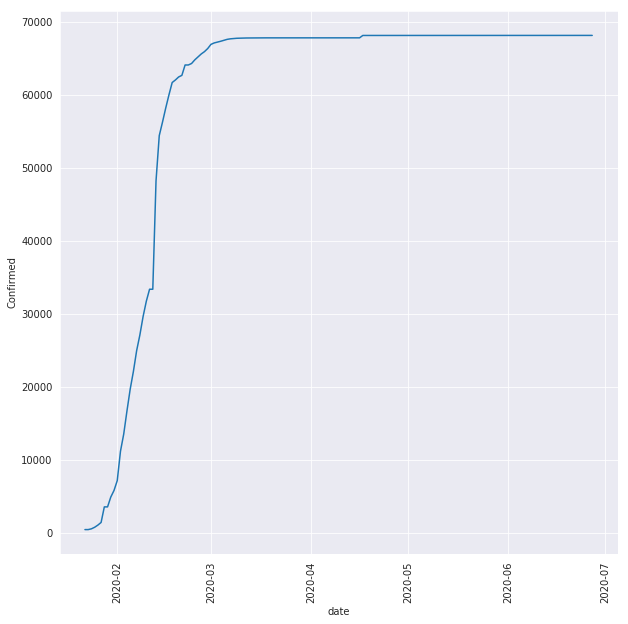

In [377]:
sns.lineplot(x='date', y='Confirmed', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

#### Notice the sharp increase in number of deaths, when the curve had already flattened.

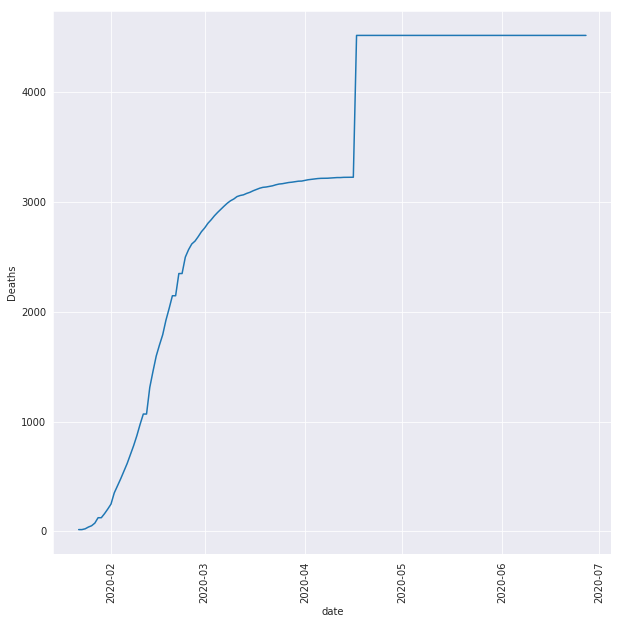

In [378]:
sns.lineplot(x='date', y='Deaths', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

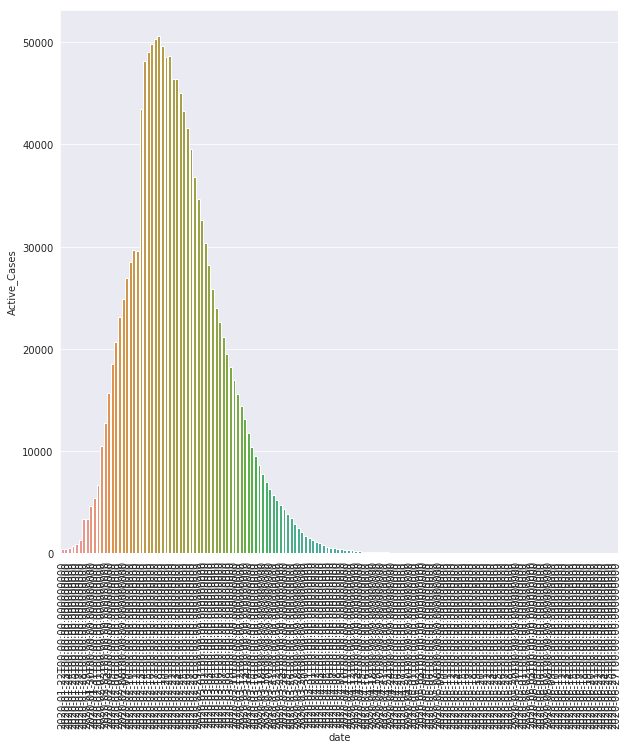

In [379]:
sns.barplot(x='date', y='Active_Cases', data=df_china.loc[df_china.Province_State == 'Hubei'])
plt.xticks(rotation=90)
plt.show()

In [47]:
df_china.groupby(['Province_State'])['Deaths'].max().sort_values(ascending=False)

Province_State
Hubei             4512
Henan               22
Heilongjiang        13
Beijing              9
Guangdong            8
Hong Kong            7
Shanghai             7
Shandong             7
Hainan               6
Anhui                6
Chongqing            6
Hebei                6
Hunan                4
Shaanxi              3
Sichuan              3
Tianjin              3
Xinjiang             3
Gansu                2
Liaoning             2
Jilin                2
Guangxi              2
Yunnan               2
Guizhou              2
Fujian               1
Zhejiang             1
Inner Mongolia       1
Jiangxi              1
Macau                0
Ningxia              0
Qinghai              0
Shanxi               0
Tibet                0
Jiangsu              0
Name: Deaths, dtype: int64

In [398]:
yesterday = (dt.datetime.now().date() - dt.timedelta(days=1)).strftime('%Y-%m-%d')

In [399]:
yesterday

'2020-06-27'

In [416]:
df1[df1.date == yesterday].groupby(['Country_Region']).sum().sort_values(by='Deaths', ascending=False).head(10)

,Confirmed,Deaths,Recovered,Active,Active_Cases
Country_Region,,,,,
US,2467554,125039,670809,1590790,1671706
Brazil,1274974,55961,702399,516614,516614
United Kingdom,310836,43498,1363,265975,265975
Italy,239961,34708,187615,17638,17638
France,199473,29781,75773,93919,93919
Spain,247905,28338,150376,69191,69191
Mexico,208392,25779,156827,25786,25786
India,508953,15685,295881,197387,197387
Iran,217724,10239,177852,29633,29633


In [401]:
df2 = df1.loc[df1.date == yesterday].groupby(['Province_State']).max()#.sort_values(by=['Deaths', 'Confirmed', 'Active', 'Recovered'], ascending=['False', 'False', 'False', 'False'])

### Analysis

- Top 10 countries with maximum fatalities
- Top 10 Provincies in US with maximum fatalities
- Countries with highest fatalities to recovery ratio
- Countries with maximum recovery rate
- Country with most active cases
- Country with largest single day spike in: 
    - Deaths
    - Confirmed
    - Recovered

#### Top Provinces / States with Maximum Fatalities

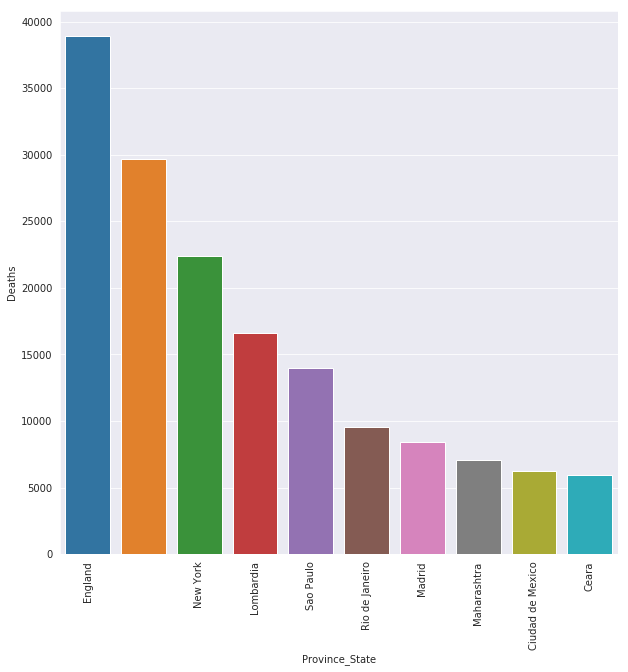

In [470]:
provincies_with_maximum_fatalities = df2.sort_values(by='Deaths', ascending=False)
top_10_provinces_with_maximum_fatalities = provincies_with_maximum_fatalities.head(10)
sns.barplot(data = top_10_provinces_with_maximum_fatalities, 
            x=top_10_provinces_with_maximum_fatalities.index, 
            y='Deaths')
plt.xticks(rotation=90)
plt.show()

#### Top 10 countries with maximum fatalities

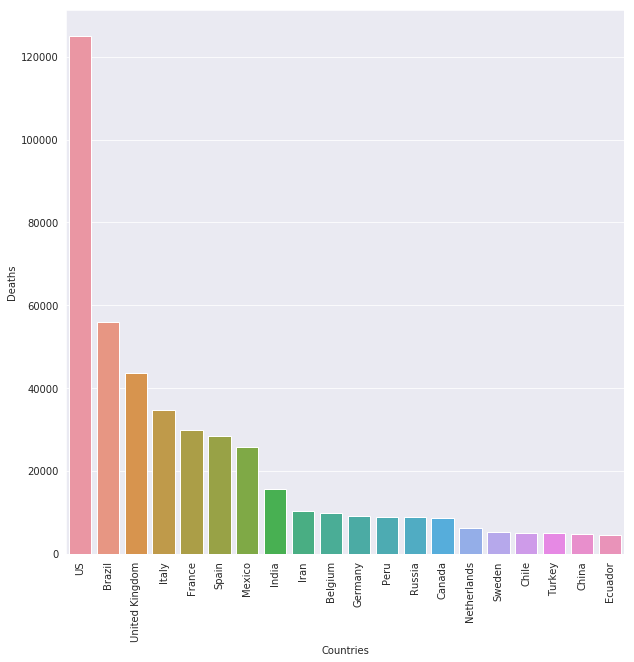

In [471]:
top_20_countries_most_deaths = df1[df1.date == yesterday].groupby(['Country_Region']).sum().sort_values(by='Deaths', ascending=False).head(20)
sns.barplot(data = top_20_countries_most_deaths, x=top_20_countries_most_deaths.index, y='Deaths')
plt.xticks(rotation=90)
plt.xlabel('Countries')
plt.show()

#### Top 10 Countries with most active cases

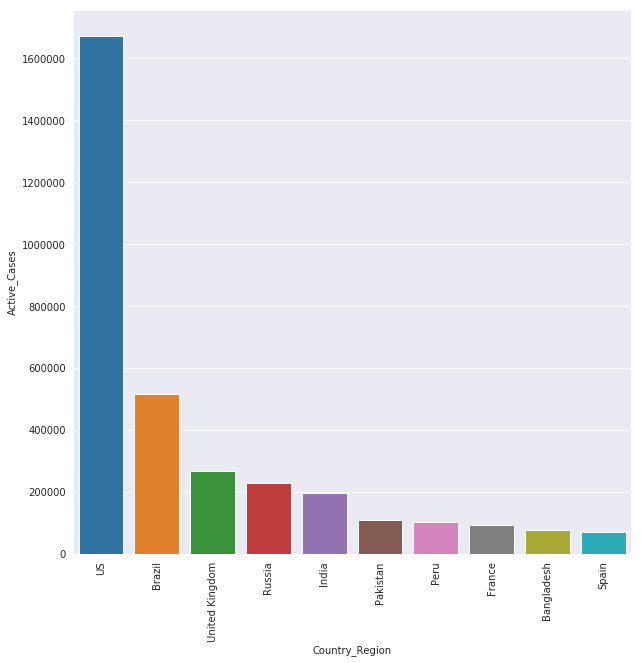

In [473]:
df3 = df1.loc[df1.date == yesterday].groupby(['Country_Region'])['Active_Cases'].sum()#.iloc[1:, :].head(10)
top_20_countries_most_active_cases = df3.sort_values(ascending=False)[:10]
sns.barplot(x=top_20_countries_most_active_cases.index, y=top_20_countries_most_active_cases)
plt.xticks(rotation=90)
plt.show()

#### Countries with most recoveries

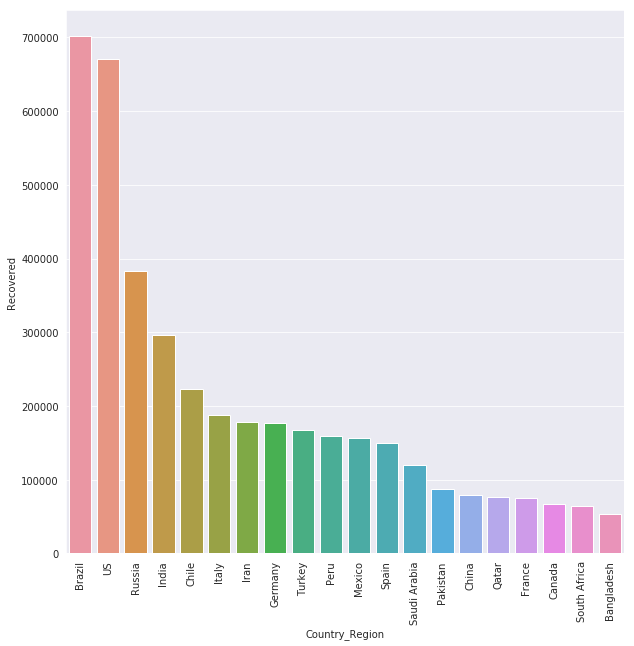

In [430]:
df3 = df1.loc[df1.date == yesterday].groupby(['Country_Region'])['Recovered'].sum()
top_20_countries_most_recovered_cases = df3.sort_values(ascending=False)[:20]
sns.barplot(x=top_20_countries_most_recovered_cases.index, y=top_20_countries_most_recovered_cases)
plt.xticks(rotation=90)
plt.show()

#### Top 10 Countries with Highest Death to Recovery Ratios

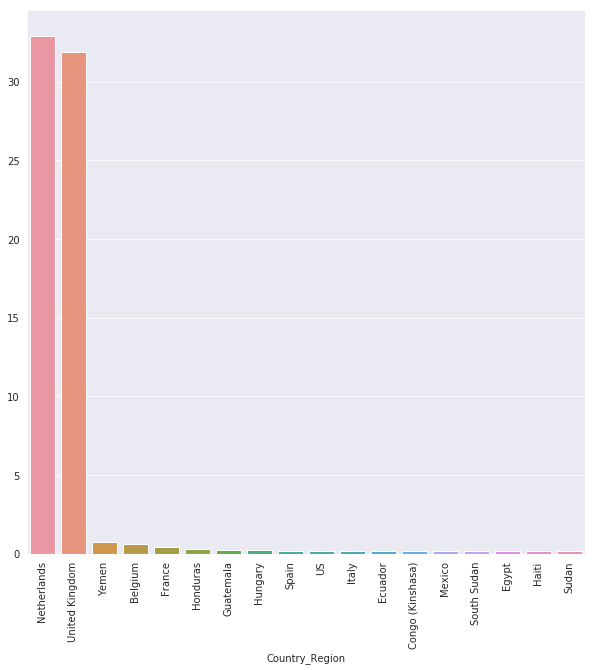

In [474]:
df3 = df1.loc[df1.date == yesterday].groupby('Country_Region').sum()
df3['Death_Recovery_Ratio'] = df3['Deaths'] / df3['Recovered']
top_20_highest_death_recovery_ratio = df3.sort_values('Death_Recovery_Ratio', ascending=False).head(20)
top_20_highest_death_recovery_ratio = top_20_highest_death_recovery_ratio[top_20_highest_death_recovery_ratio['Death_Recovery_Ratio'] != np.inf]
sns.barplot(x=top_20_highest_death_recovery_ratio.index, y=top_20_highest_death_recovery_ratio['Death_Recovery_Ratio'].values)
plt.xticks(rotation=90)
plt.show()

#### Note:

- Netherlands and UK have highest death to recovery rate i.e 1 person recovers when ~33 people die.

#### Comparing Top Countries Recovery Rates

In [468]:
countries = ['China', 'US', 'India', 'China', 'France', 'Italy', 'Iran', 'Belgium']

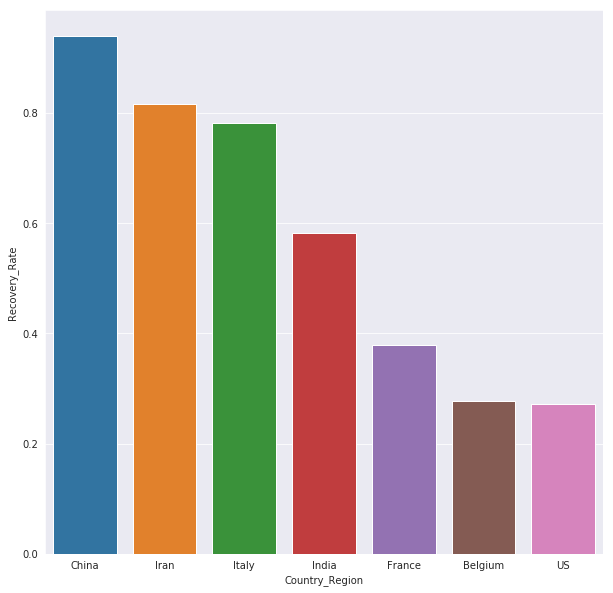

In [475]:
df_new = df1[df1.date == yesterday].groupby(['Country_Region']).sum()
df_new.loc[:, 'Recovery_Rate'] =  df_new['Recovered'] / df_new['Confirmed']
df_new = df_new.sort_values(by='Recovery_Rate', ascending=False)
df_recovery_rates = df_new.loc[countries].drop_duplicates().sort_values(by='Recovery_Rate', ascending=False)
sns.barplot(data=df_recovery_rates, x=df_recovery_rates.index, y='Recovery_Rate')
plt.show()

#### Top US Provinces with maximum impact

In [72]:
us_state_abbrev = """Alabama - AL

Alaska - AK

Arizona - AZ

Arkansas - AR

California - CA

Colorado - CO

Connecticut - CT

Delaware - DE

Florida - FL

Georgia - GA

Hawaii - HI

Idaho - ID

Illinois - IL

Indiana - IN

Iowa - IA

Kansas - KS

Kentucky - KY

Louisiana - LA

Maine - ME

Maryland - MD

Massachusetts - MA

Michigan - MI

Minnesota - MN

Mississippi - MS

Missouri - MO

Montana - MT

Nebraska - NE

Nevada - NV

New Hampshire - NH

New Jersey - NJ

New Mexico - NM

New York - NY

North Carolina - NC

North Dakota - ND

Ohio - OH

Oklahoma - OK

Oregon - OR

Pennsylvania - PA

Rhode Island - RI

South Carolina - SC

South Dakota - SD

Tennessee - TN

Texas - TX

Utah - UT

Vermont - VT

Virginia - VA

Washington - WA

West Virginia - WV

Wisconsin - WI

Wyoming - WY
"""

In [73]:
us_state_mapping = {}
pattern = re.compile(r'(\w+\s?\w+)\s+-\s+(\w+)', re.MULTILINE)
matches = pattern.finditer(us_state_abbrev) 
for match in matches:
    us_state_mapping[match.group(2)] = match.group(1)
    print(f"{match.group(2)} : {match.group(1)}")
us_state_mapping

AL : Alabama
AK : Alaska
AZ : Arizona
AR : Arkansas
CA : California
CO : Colorado
CT : Connecticut
DE : Delaware
FL : Florida
GA : Georgia
HI : Hawaii
ID : Idaho
IL : Illinois
IN : Indiana
IA : Iowa
KS : Kansas
KY : Kentucky
LA : Louisiana
ME : Maine
MD : Maryland
MA : Massachusetts
MI : Michigan
MN : Minnesota
MS : Mississippi
MO : Missouri
MT : Montana
NE : Nebraska
NV : Nevada
NH : New Hampshire
NJ : New Jersey
NM : New Mexico
NY : New York
NC : North Carolina
ND : North Dakota
OH : Ohio
OK : Oklahoma
OR : Oregon
PA : Pennsylvania
RI : Rhode Island
SC : South Carolina
SD : South Dakota
TN : Tennessee
TX : Texas
UT : Utah
VT : Vermont
VA : Virginia
WA : Washington
WV : West Virginia
WI : Wisconsin
WY : Wyoming


{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

In [74]:
df_us = df1.loc[(df1.Country_Region == 'US')]
df_us.loc[:, 'state'] = df_us.Province_State.str.strip().str.split(',', n=1).apply(lambda x: x[-1])

In [77]:
def map_us_state_abbreviation_to_state_name(abbrev):
    abbrev = abbrev.strip()
    if abbrev in us_state_mapping:
        return us_state_mapping[abbrev]
    elif 'Diamond Princess' in abbrev or 'Recovered' in abbrev:
        return np.nan
    
    else:
        return abbrev

#### Deaths

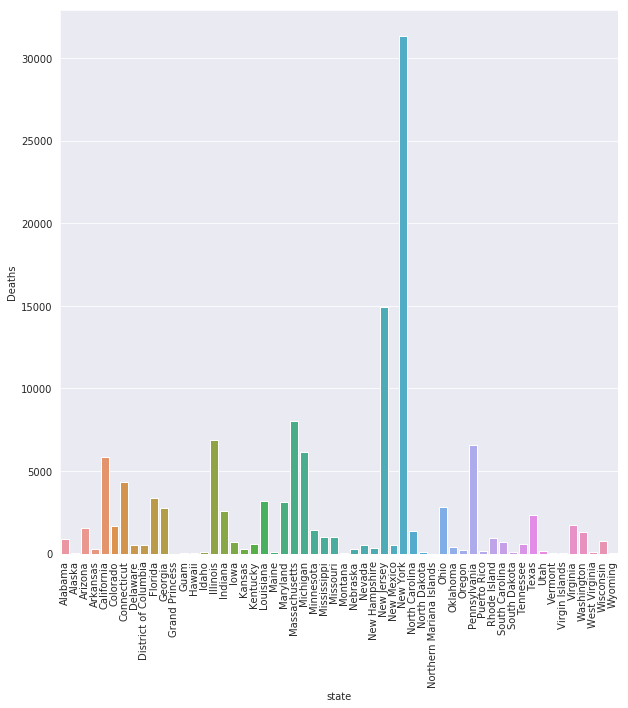

In [476]:
df_us.loc[:, 'state'] = df_us['state'].map(map_us_state_abbreviation_to_state_name)
df_us = df_us.dropna(subset=['state'])
df5 = df_us[df_us.date == yesterday].groupby('state').sum()
sns.barplot(x=df5.index, y=df5['Deaths'])
plt.xticks(rotation=90)
plt.show()

#### Active Cases 

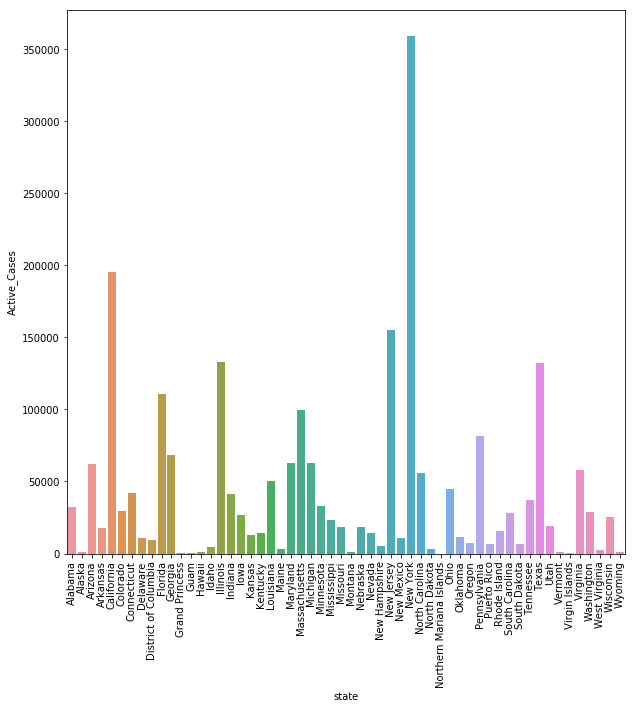

In [83]:
sns.barplot(x=df5.index, y=df5['Active_Cases'])
plt.xticks(rotation=90)
plt.show()

### Global Confirmed Cases

In [477]:
base_dir = '../data/Global/csse_covid_19_time_series/'
abs_path = os.path.abspath(base_dir)
files = os.listdir(abs_path)
csv_files = filter(lambda file: '.csv' in file, files)
csv_abs_path = [os.path.join(abs_path, csv_file) for csv_file in csv_files]
csv_abs_path = sorted(csv_abs_path)
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [478]:
df_global_confirmed = pd.DataFrame(l, columns=columns)
df_global_confirmed_min = df_global_confirmed.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_confirmed_min.columns if 'Country' not in col]
df_trans = df_global_confirmed_min.transpose()
df_trans.columns = df_trans.iloc[0, :]
df_trans = df_trans.iloc[1:, :]
df_trans = df_trans.astype(np.int)
df_trans.index = pd.to_datetime(df_trans.index)

#### Cleaning data for UK and Netherlands

In [105]:
df_uk = df_trans['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans['Netherlands']
flag = [False, False, False, True]
df_trans['Holland'] = df_netherlands.loc[:, flag]

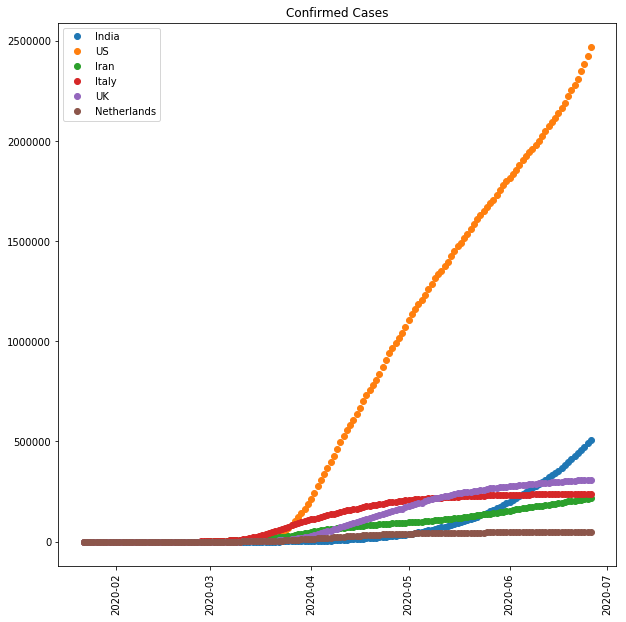

In [114]:
plt.plot_date(x=df_trans.index, y=df_trans['India'], label='India')
plt.plot_date(x=df_trans.index, y=df_trans['US'], label='US')
plt.plot_date(x=df_trans.index, y=df_trans['Iran'], label='Iran')
plt.plot_date(x=df_trans.index, y=df_trans['Italy'], label='Italy')
plt.plot_date(x=df_trans.index, y=df_trans['UK'], label='UK')
plt.plot_date(x=df_trans.index, y=df_trans['Holland'], label='Netherlands')
plt.xticks(rotation=90)
plt.title('Confirmed Cases')
plt.legend()
plt.show()

### Global Deaths

In [480]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_deaths_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]
df_global_deaths = pd.DataFrame(l, columns=columns)
df_global_deaths_min = df_global_deaths.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_confirmed_min.columns if 'Country' not in col]
df_trans_deaths = df_global_deaths_min.transpose()
df_trans_deaths.columns = df_trans_deaths.iloc[0, :]
df_trans_deaths = df_trans_deaths.iloc[1:, :]
df_trans_deaths = df_trans_deaths.astype(np.int)
df_trans_deaths.index = pd.to_datetime(df_trans_deaths.index)

#### Cleaning data for UK and Netherlands

In [482]:
df_trans_deaths.columns[df_trans_deaths.columns == 'Netherlands']
df_uk = df_trans_deaths['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans_deaths['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans_deaths['Netherlands']
flag = [False, False, False, True]
df_trans_deaths['Holland'] = df_netherlands.loc[:, flag]

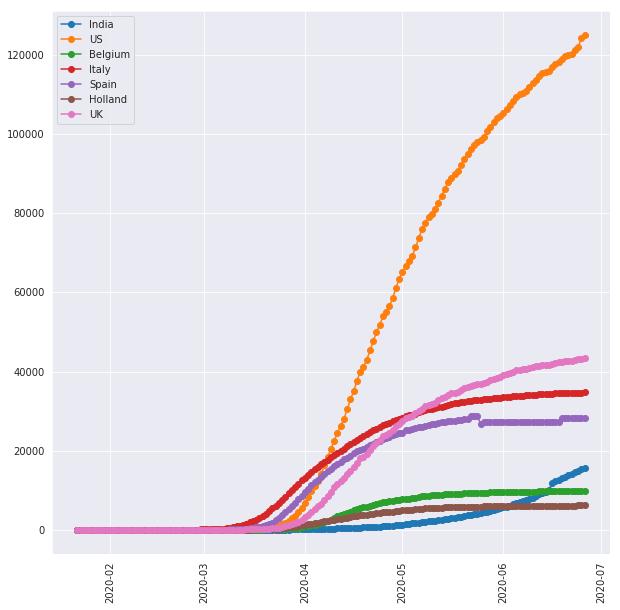

In [483]:
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['India'], label='India', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['US'], label='US', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Belgium'], label='Belgium', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Italy'], label='Italy', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Spain'], label='Spain', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Holland'], label='Holland', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['UK'], label='UK', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['China'], label='China', linestyle='solid')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Global Recovery

In [486]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_recovered_global.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]
df_global_recovered = pd.DataFrame(l, columns=columns)
df_global_recovered_min = df_global_recovered.drop(columns=['Province/State', 'Lat', 'Long'])
list_of_columns = [col for col in df_global_recovered_min.columns if 'Country' not in col]
df_trans_recovered = df_global_recovered_min.transpose()
df_trans_recovered.columns = df_trans_recovered.iloc[0, :]
df_trans_recovered = df_trans_recovered.iloc[1:, :]
df_trans_recovered = df_trans_recovered.astype(np.int)
df_trans_recovered.index = pd.to_datetime(df_trans_recovered.index)

In [487]:
df_trans_recovered.columns[df_trans_recovered.columns == 'Netherlands']
df_uk = df_trans_recovered['United Kingdom']
flag = [False, False, False, False, False, False, True, False, False, False, False, False]
df_trans_recovered['UK'] = df_uk.loc[:, flag]
df_netherlands = df_trans_recovered['Netherlands']
flag = [False, False, False, True]
df_trans_recovered['Holland'] = df_netherlands.loc[:, flag]

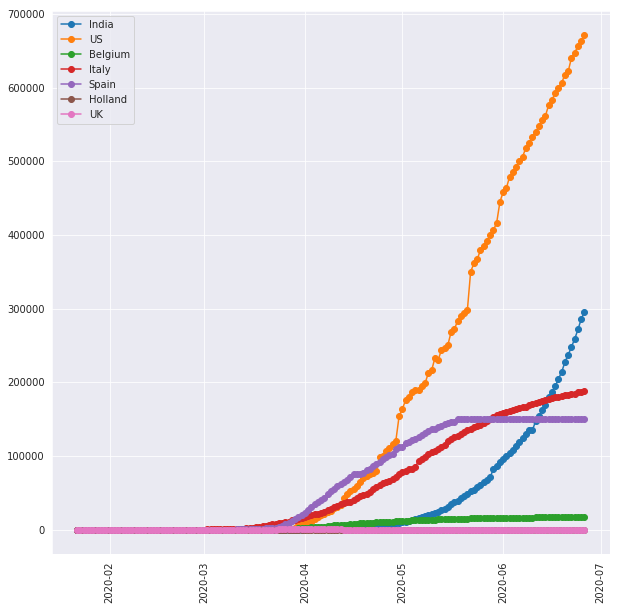

In [488]:
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['India'], label='India', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['US'], label='US', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Belgium'], label='Belgium', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Italy'], label='Italy', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Spain'], label='Spain', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Holland'], label='Holland', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['UK'], label='UK', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['China'], label='China', linestyle='solid')
# plt.plot_date(x=df_trans.index, y=df_trans['United Kingdom'], label='UK', linestyle='solid')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Comparing Confirmed vs Recovered vs Deaths for selected countries

### India

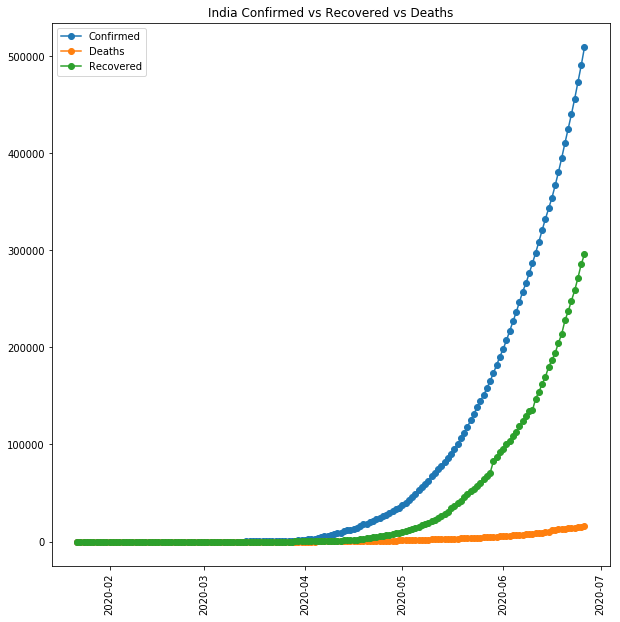

In [180]:
plt.plot_date(x=df_trans.index, y=df_trans['India'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['India'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['India'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('India Confirmed vs Recovered vs Deaths')
plt.show()

### UK

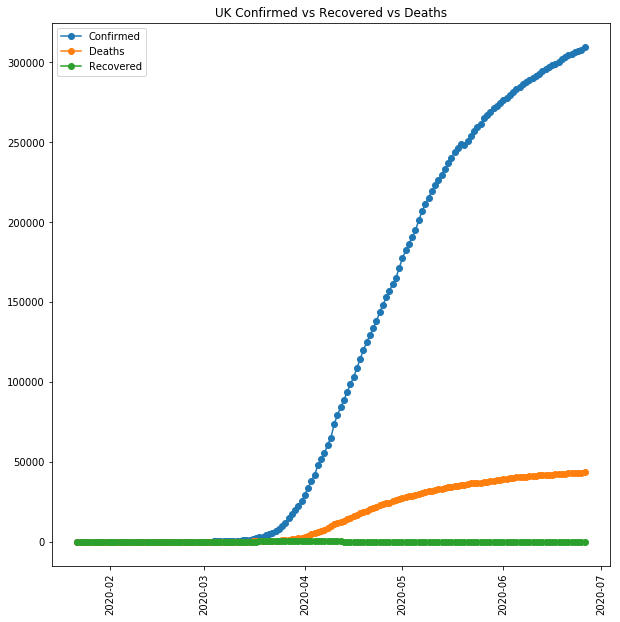

In [181]:
plt.plot_date(x=df_trans.index, y=df_trans['UK'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['UK'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['UK'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('UK Confirmed vs Recovered vs Deaths')
plt.show()

### US

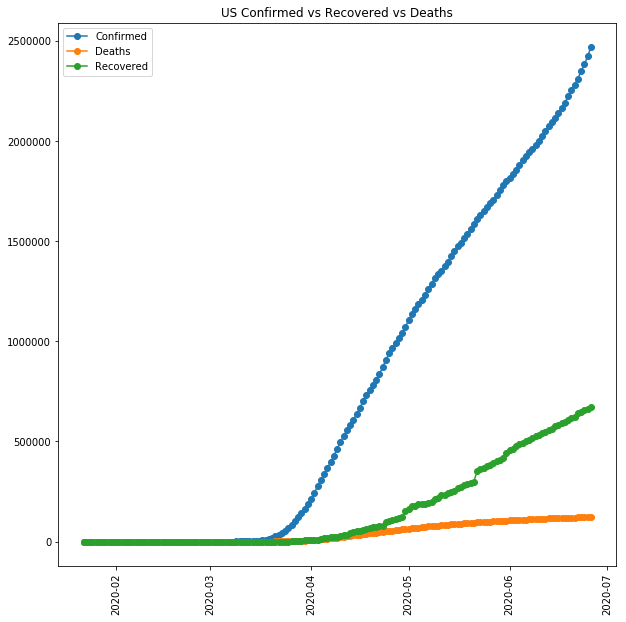

In [182]:
plt.plot_date(x=df_trans.index, y=df_trans['US'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['US'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['US'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('US Confirmed vs Recovered vs Deaths')
plt.show()

### Holland

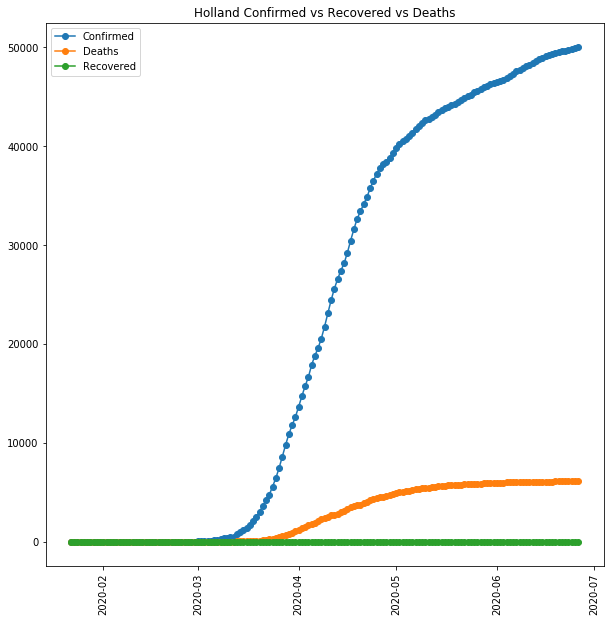

In [183]:
plt.plot_date(x=df_trans.index, y=df_trans['Holland'], label='Confirmed', linestyle='solid')
plt.plot_date(x=df_trans_deaths.index, y=df_trans_deaths['Holland'], label='Deaths', linestyle='solid')
plt.plot_date(x=df_trans_recovered.index, y=df_trans_recovered['Holland'], label='Recovered', linestyle='solid')

plt.xticks(rotation=90)
plt.legend()
plt.title('Holland Confirmed vs Recovered vs Deaths')
plt.show()

### India's fight against corona virus

### Active Cases

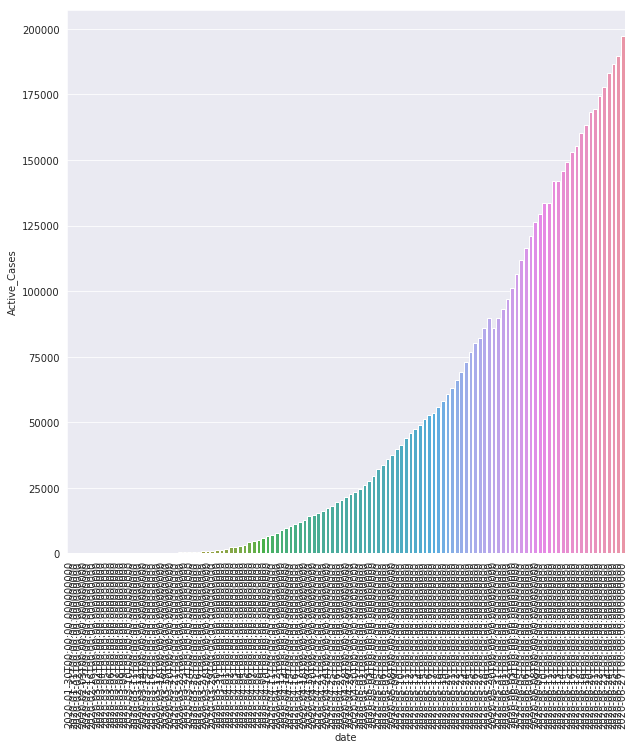

In [439]:
sns.barplot(x='date', y='Active_Cases', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

### Deaths

In [434]:
df_india = df1.loc[df1.Country_Region == 'India'].groupby(['Country_Region', 'date']).sum().reset_index()

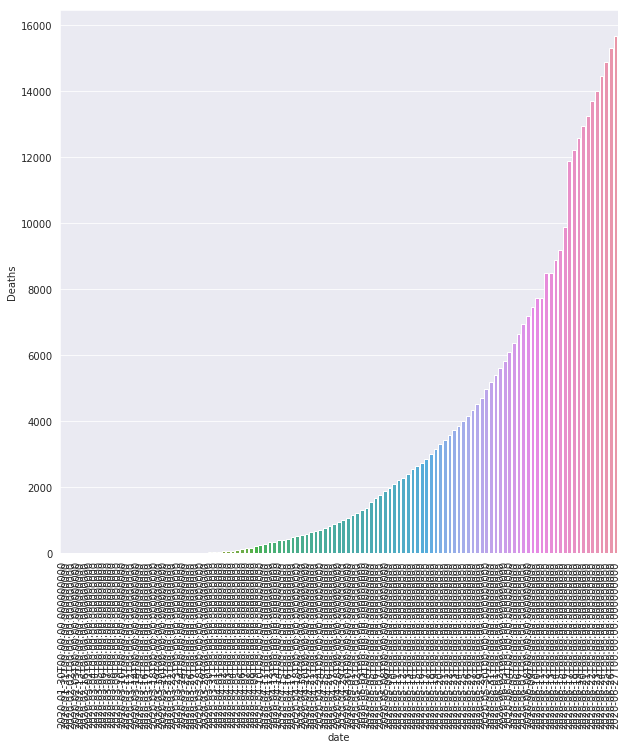

In [435]:
sns.barplot(x='date', y='Deaths', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

### Recovery

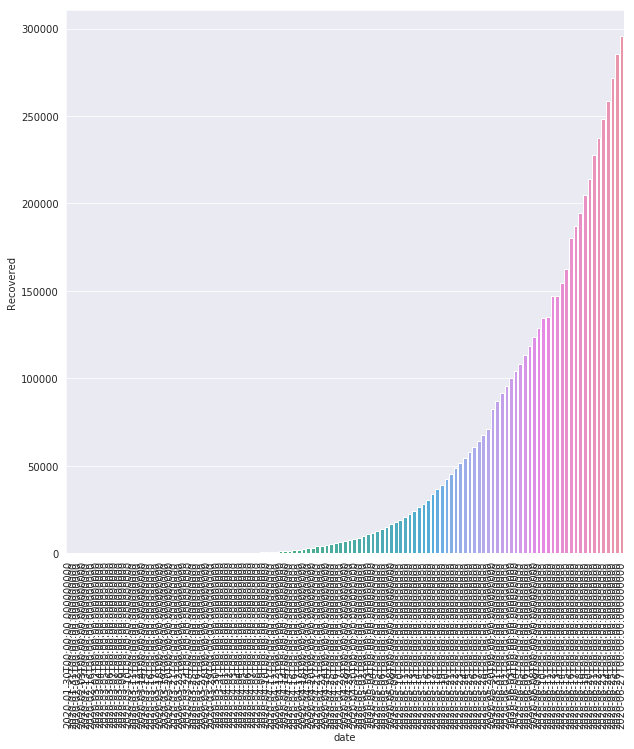

In [437]:
sns.barplot(x='date', y='Recovered', data=df_india)
plt.xticks(rotation=90)
# plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000])
plt.show()

## Comparing India and New York Graphs

- Is India following New York trajectory?

#### India vs New York Confirmed Cases

In [441]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [442]:
df_us_confirmed = pd.DataFrame(l, columns=columns)
df_us_confirmed_min = df_us_confirmed.drop(columns=['Country_Region', 'Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3',
                                                   'FIPS','Admin2', 'Combined_Key'])
list_of_columns = [col for col in df_us_confirmed_min.columns if 'State' not in col]
df_trans_us_confirmed = df_us_confirmed_min.transpose()
df_trans_us_confirmed.columns = df_trans_us_confirmed.iloc[0, :]
df_trans_us_confirmed = df_trans_us_confirmed.iloc[1:, :]
df_trans_us_confirmed = df_trans_us_confirmed.astype(np.int)
df_trans_us_confirmed.index = pd.to_datetime(df_trans_us_confirmed.index)
df_trans_us_confirmed['NY'] = df_trans_us_confirmed['New York'].agg(np.sum, axis=1)

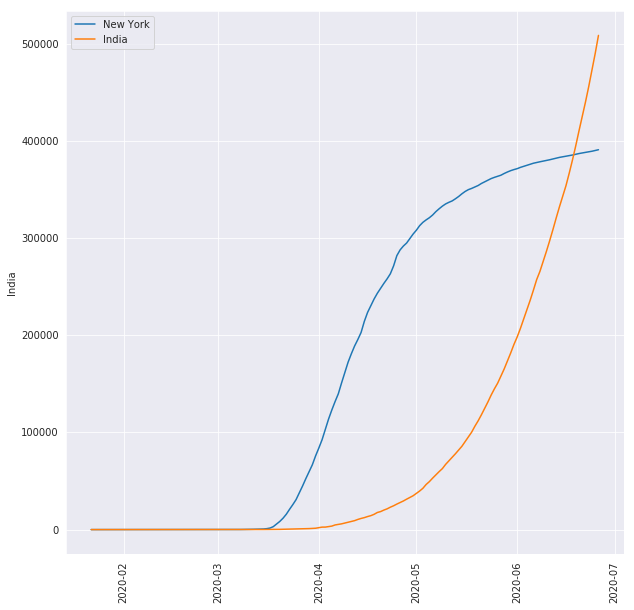

In [443]:
sns.lineplot(x=df_trans_us_confirmed.index, y=df_trans_us_confirmed['NY'], label='New York')
sns.lineplot(x=df_trans.index, y=df_trans['India'], label='India')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#### Yes, India's trajectory is similar to New York. Only difference is that New York has reached the peak, whereas India is still on the rise.

#### India vs New York Deaths

In [446]:
columns = []
with open('../data/Global/csse_covid_19_time_series/time_series_covid19_deaths_US.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    columns = next(spamreader) 
    l = [i for i in spamreader]

In [447]:
df_us_deaths = pd.DataFrame(l, columns=columns)
df_us_deaths_min = df_us_deaths.drop(columns=['Country_Region', 'Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3',
                                                   'FIPS','Admin2', 'Combined_Key', 'Population'])
list_of_columns = [col for col in df_us_deaths_min.columns if 'State' not in col]
df_trans_us_deaths = df_us_deaths_min.transpose()
df_trans_us_deaths.columns = df_trans_us_deaths.iloc[0, :]
df_trans_us_deaths = df_trans_us_deaths.iloc[1:, :]
df_trans_us_deaths = df_trans_us_deaths.astype(np.int)
df_trans_us_deaths.index = pd.to_datetime(df_trans_us_deaths.index)
df_trans_us_deaths['NY'] = df_trans_us_deaths['New York'].agg(np.sum, axis=1)

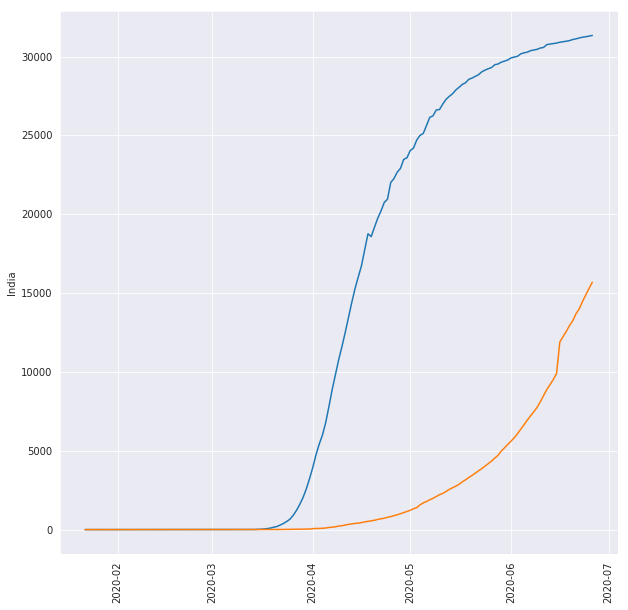

In [448]:
sns.lineplot(x=df_trans_us_deaths.index, y=df_trans_us_deaths['NY'])
sns.lineplot(x=df_trans_deaths.index, y=df_trans_deaths['India'])
plt.xticks(rotation=90)
plt.show()

### Time Series Forecasting using ARIMA model


In [1]:
def get_list_of_arma_model_parameters(df, no_of_lags):
    """ Helper Function to return list of tuple of ARMA params like (ar, ma, aic, bic)"""
    list_tup = []
    for i in range(10):
        for j in range(10):
            try:
                ARIMA_model = ARIMA(df, order=(i, no_of_lags, j)).fit(transparams=False)
                t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
                list_tup.append(t)
            except Exception as e:
                print(e)
    return list_tup

In [2]:
def get_best_ar_ma_value(list_of_tup):
    """ Helper Function to return best fit params from list of tuple of ARMA params like (ar, ma, aic, bic)"""
    least_bic = list_tup[0][3]
    best_params = list_tup[0]
    list_of_best_params = []
    for tup in list_of_tup:
        if tup[3] < least_bic:
            best_params = tup
            least_bic = tup[3]
    return best_params

### US Deaths

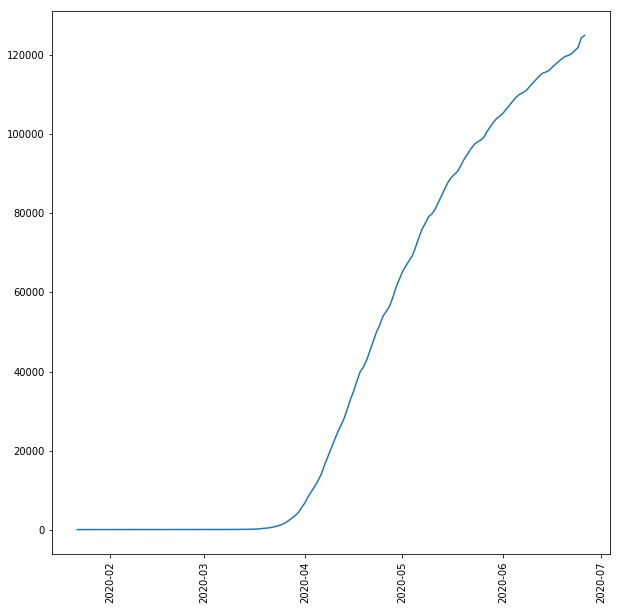

In [209]:
df_trans_deaths_us = df_trans_deaths[['US']]
plt.plot(df_trans_deaths_us)
plt.xticks(rotation=90)
plt.show()

In [210]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

Country/Region,US
2020-06-22,423.0
2020-06-23,829.0
2020-06-24,754.0
2020-06-25,2425.0
2020-06-26,629.0


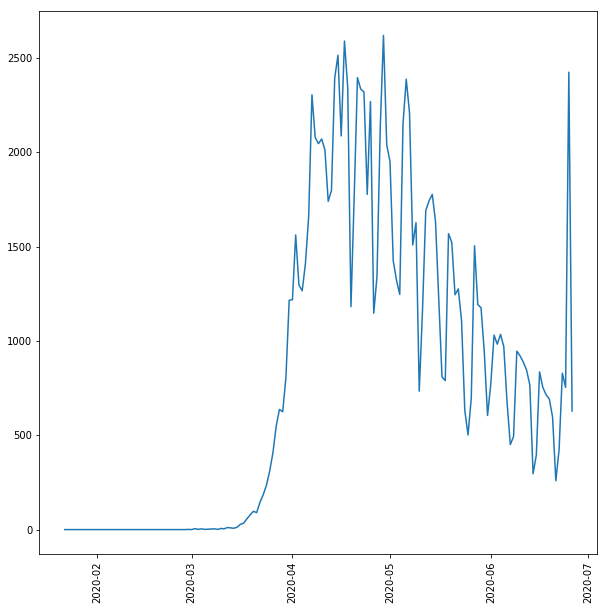

In [211]:
plt.plot(df_us1)
plt.xticks(rotation=90)
plt.show()

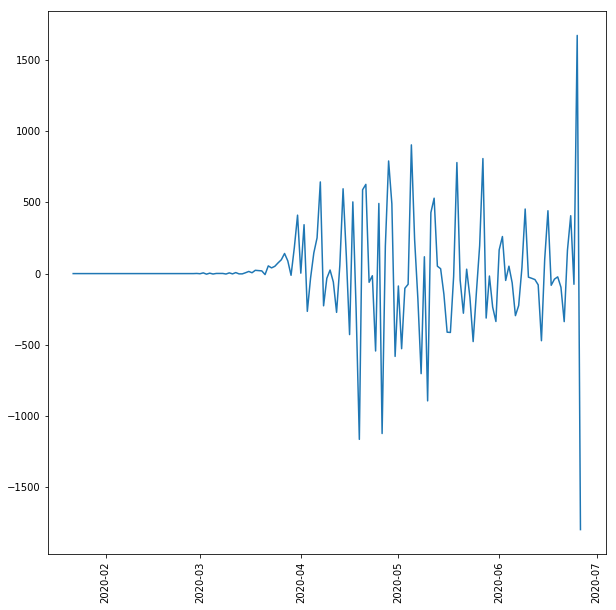

In [212]:
df_us2 = df_us1.diff().fillna(df_us1)
plt.plot(df_us2)
plt.xticks(rotation=90)
plt.show()

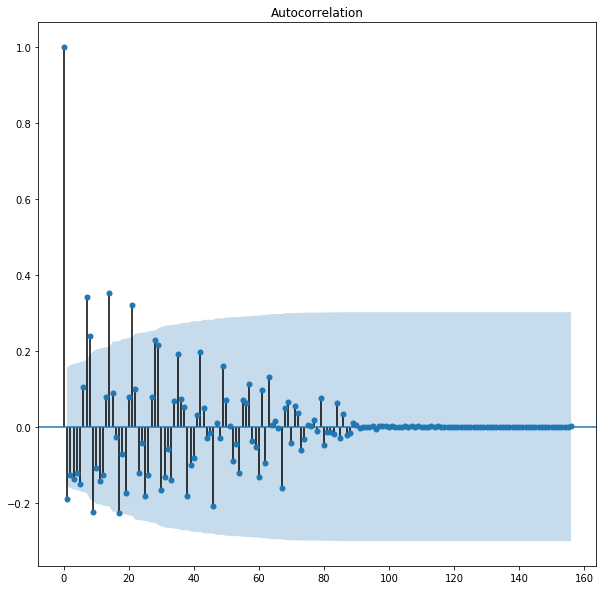

In [213]:
plot_acf(df_us2)
plt.show()

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


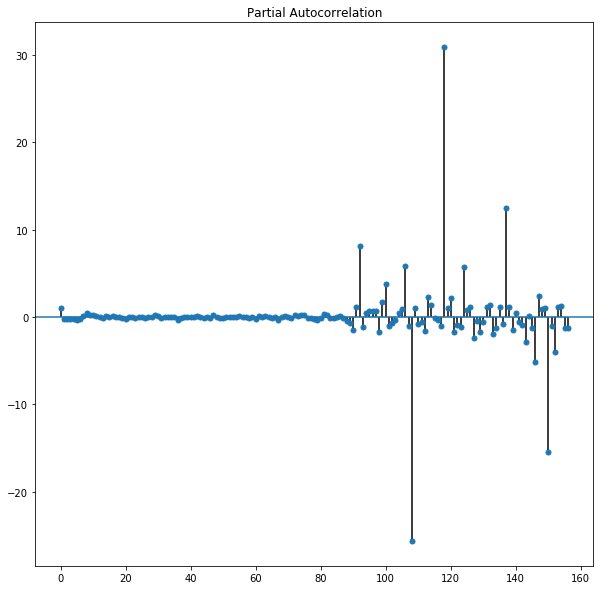

In [214]:
plot_pacf(df_us2)
plt.show()

In [215]:
ARIMA_model = ARIMA(df_trans_deaths_us, order=(5, 2, 3)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [216]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D2.US   No. Observations:                  155
Model:                 ARIMA(5, 2, 3)   Log Likelihood               -1081.321
Method:                       css-mle   S.D. of innovations            256.082
Date:                Sun, 28 Jun 2020   AIC                           2182.642
Time:                        15:00:54   BIC                           2213.076
Sample:                    01-24-2020   HQIC                          2195.003
                         - 06-26-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.4133      7.513      0.854      0.395      -8.312      21.139
ar.L1.D2.US     0.1532      0.203      0.757      0.450      -0.244       0.550
ar.L2.D2.US    -0.4785      0.151     -3.171      0.002      -0.774      -0.183
ar.L3.D2.US    -0.4364      0.142     -3.070      0.003      -0.715      -0.158
ar.L4.D2.US    -0.3128      0.095     -3.282      0.001      -0.500      -0.126
ar.L5.D2.US    -0.4105      0.121     -3.406      0.001      -0.647      -0.174
ma.L1.D2.US    -0.8124      0.203     -3.995      0.000      -1.211      -0.414
ma.L2.D2.US     0.5415      0.251      2.155      0.033       0.049       1.034
ma.L3.D2.US     0.1705      0.186      0.918      0.360      -0.193       0.534
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6316           -0.7867j            1.0089           -0.1423
AR.2            0.6316           +0.7867j            1.0089            0.1423
AR.3           -1.3907           -0.0000j            1.3907           -0.5000
AR.4           -0.3174           -1.2730j            1.3119           -0.2889
AR.5           -0.3174           +1.2730j            1.3119            0.2889
MA.1            0.6710           -0.9209j            1.1394           -0.1498
MA.2            0.6710           +0.9209j            1.1394            0.1498
MA.3           -4.5189           -0.0000j            4.5189           -0.5000
-----------------------------------------------------------------------------
"""

In [217]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-06-15', typ='levels')

In [218]:
arma_predict

2020-06-05    109566.427436
2020-06-06    110180.081405
2020-06-07    110626.327244
2020-06-08    111171.886774
2020-06-09    111865.322156
2020-06-10    113056.176302
2020-06-11    113985.409226
2020-06-12    114706.643763
2020-06-13    115314.232336
2020-06-14    115916.219789
2020-06-15    116257.653752
Freq: D, dtype: float64

In [219]:
undiff1 = df_us2.cumsum().fillna(df_us2)
undiff2 = df_us1.cumsum().fillna(df_us1)

### Mean Absolute Error for Forecast Evaluation

In [220]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-07-25', typ='levels')
ser2 = arma_predict2

In [221]:
ser2.diff()

2020-01-24            NaN
2020-01-25       1.398683
2020-01-26       1.222705
2020-01-27       2.033722
2020-01-28       2.712516
2020-01-29       6.655294
2020-01-30       5.316793
2020-01-31      -0.920089
2020-02-01      -5.306420
2020-02-02      -3.682884
2020-02-03      -0.623044
2020-02-04       1.501682
2020-02-05       2.158317
2020-02-06       1.115517
2020-02-07      -0.736350
2020-02-08      -1.586417
2020-02-09      -1.005921
2020-02-10       0.069619
2020-02-11       0.799980
2020-02-12       0.808565
2020-02-13       0.201169
2020-02-14      -0.446600
2020-02-15      -0.602366
2020-02-16      -0.277867
2020-02-17       0.158268
                 ...     
2020-07-01    1355.112708
2020-07-02    1444.231578
2020-07-03    1220.928104
2020-07-04     881.553831
2020-07-05     767.810857
2020-07-06     728.895001
2020-07-07     974.660010
2020-07-08    1294.335771
2020-07-09    1433.518054
2020-07-10    1269.430058
2020-07-11     993.217392
2020-07-12     783.733746
2020-07-13  

### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

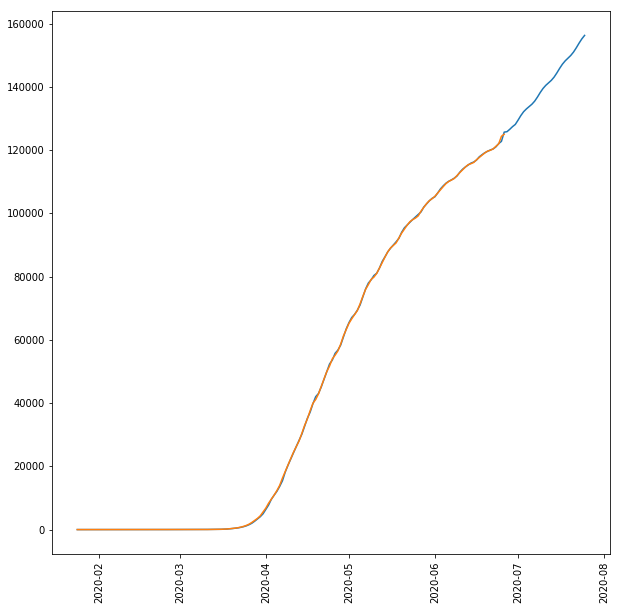

In [222]:
actual = df_trans_deaths_us.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.show()

#### Note the predicted trajectory in blue.

# India

### India Deaths

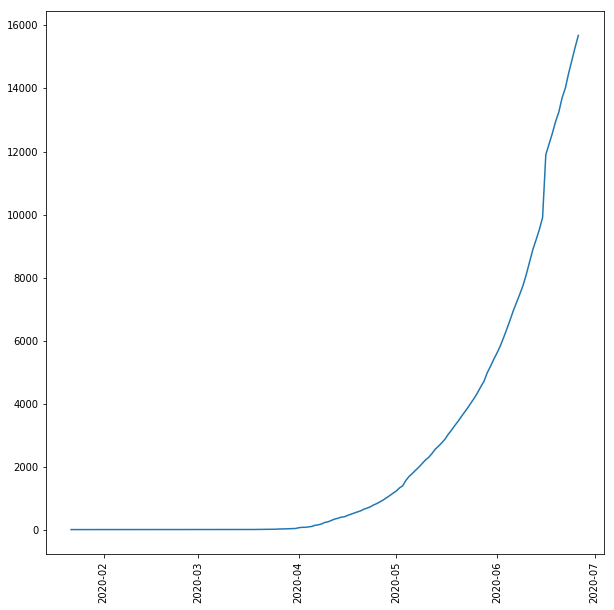

In [223]:
df_trans_deaths_ind = df_trans_deaths[['India']]
plt.plot(df_trans_deaths_ind)
plt.xticks(rotation=90)
plt.show()

In [224]:
temp = np.log(df_trans_deaths_ind)
temp = temp[temp.India != -np.inf]

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [225]:
temp.head()

Country/Region,India
2020-03-11,0.000000
2020-03-12,0.000000
2020-03-13,0.693147
2020-03-14,0.693147
2020-03-15,0.693147


In [226]:
df_deaths_ind = df_trans_deaths_ind

In [227]:
df_trans_deaths_ind = temp[temp.India != -np.inf]

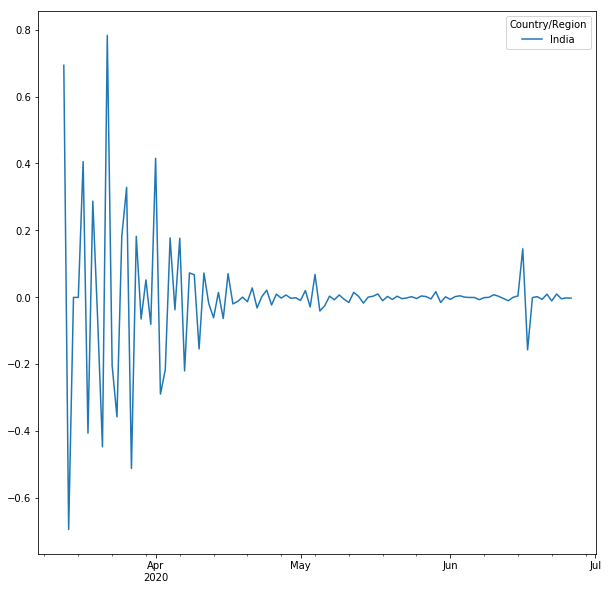

In [228]:
df_trans_deaths_ind.diff().dropna().diff().dropna().plot()

In [229]:
df_ind1 = df_trans_deaths_ind.diff().fillna(df_trans_deaths_ind)
df_ind1.tail()

Country/Region,India
2020-06-22,0.022520
2020-06-23,0.032649
2020-06-24,0.028466
2020-06-25,0.026960
2020-06-26,0.024787


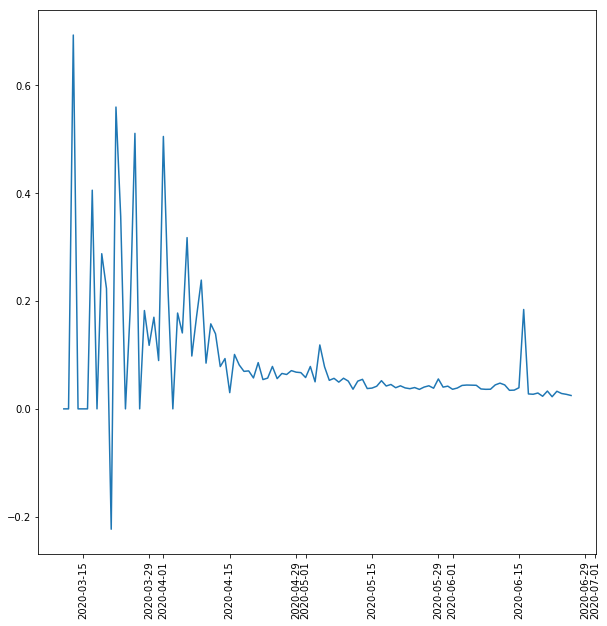

In [230]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

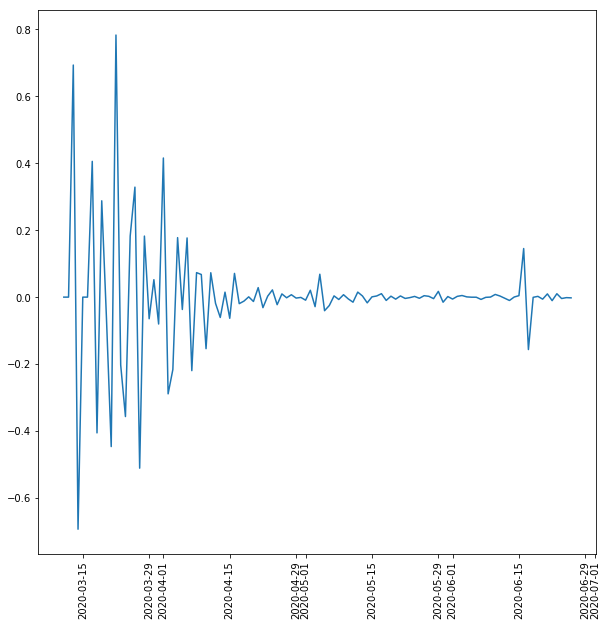

In [231]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

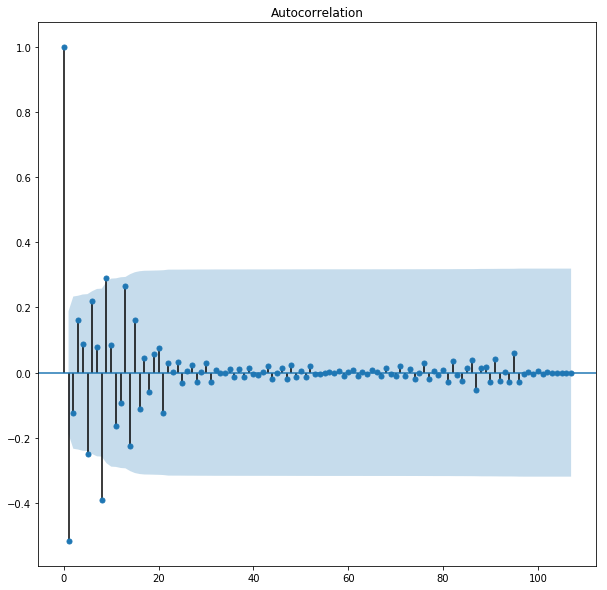

In [232]:
plot_acf(df_ind2)
plt.show()

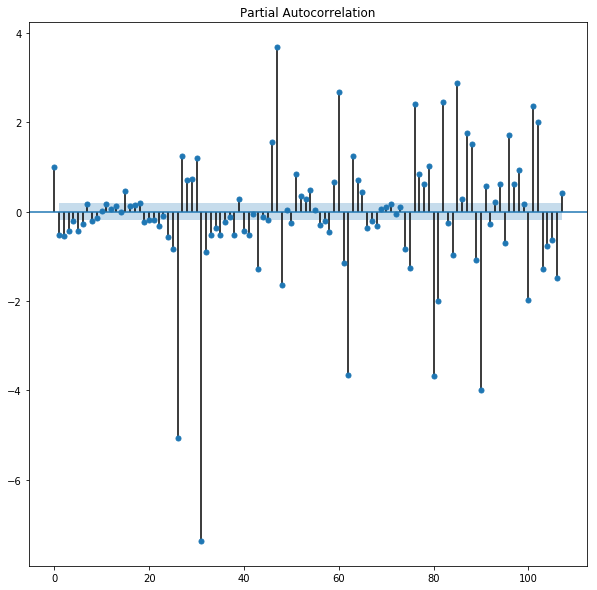

In [233]:
plot_pacf(df_ind2)
plt.show()

In [ ]:
def get_list_of_arma_model_parameters(df, no_of_lags):
    """ Helper Function to return list of tuple of ARMA params like (ar, ma, aic, bic)"""
    list_tup = []
    for i in range(10):
        for j in range(10):
            try:
                ARIMA_model = ARIMA(df, order=(i, no_of_lags, j)).fit(transparams=False)
                t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
                list_tup.append(t)
            except Exception as e:
                print(e)
    return list_tup

In [234]:
BIC = []
AIC = []
list_tup = []
for i in range(10):
    for j in range(10):
        try:
            ARIMA_model = ARIMA(temp, order=(i, 2, j)).fit(transparams=False)
#             result = ARIMA_model.fit()
            BIC.append(ARIMA_model.bic)
            AIC.append(ARIMA_model.aic)
            print(f'i: {i} => j: {j}')
            t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
            list_tup.append(t)
        except Exception as e:
            print(e)
            pass

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

i: 0 => j: 0
i: 0 => j: 1
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed i

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 1 => j: 3


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 1 => j: 4
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 1 => j: 6


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 1 => j: 7


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 1 => j: 8


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 1 => j: 9
i: 2 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 2 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 2 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 2 => j: 3


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 2 => j: 4


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 2 => j: 5


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 2 => j: 6
i: 2 => j: 7


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so

i: 2 => j: 8
i: 2 => j: 9
i: 3 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so

i: 3 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 3 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 3 => j: 3


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 3 => j: 4


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 3 => j: 5


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 3 => j: 6


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so

i: 3 => j: 7
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
i: 4 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 4 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 4 => j: 2
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

i: 4 => j: 5
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 5 => j: 0
i: 5 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so

i: 5 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 5 => j: 3
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
i: 5 => j: 5
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

i: 6 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 6 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 6 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 6 => j: 3
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 6 => j: 5
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 7 => j: 0
i: 7 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 7 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 7 => j: 3
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 7 => j: 5
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 8 => j: 0
i: 8 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:649: RuntimeWarning: overflow encountered in square
  R_mat, T_mat)


i: 8 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so 

i: 8 => j: 3


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 8 => j: 4
i: 8 => j: 5


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


On entry to DLASCL parameter number 4 had an illegal value


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 8 => j: 7


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 8 => j: 8
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. C

i: 9 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 3


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 4


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 5


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 6


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


i: 9 => j: 7
i: 9 => j: 8
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [236]:
ARIMA_model = ARIMA(df_deaths_ind, order=(0, 2, 1)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [237]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.India   No. Observations:                  155
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -987.491
Method:                       css-mle   S.D. of innovations            140.789
Date:                Sun, 28 Jun 2020   AIC                           1980.983
Time:                        15:07:29   BIC                           1990.113
Sample:                    01-24-2020   HQIC                          1984.691
                         - 06-26-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.9888      1.468      2.036      0.043       0.112       5.866
ma.L1.D2.India    -0.8763      0.035    -25.255      0.000      -0.944      -0.808
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1411           +0.0000j            1.1411            0.0000
-----------------------------------------------------------------------------
"""

In [238]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-08-15', typ='levels')

In [239]:
undiff1 = df_ind2.cumsum().fillna(df_ind2)
undiff2 = df_ind1.cumsum().fillna(df_ind1)

### Mean Absolute Error for Forecast Evaluation

In [240]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-07-15', typ='levels')
ser2 = arma_predict2

In [241]:
ser2.diff()

2020-01-24           NaN
2020-01-25      1.481466
2020-01-26      1.456046
2020-01-27      1.418993
2020-01-28      1.371515
2020-01-29      1.315090
2020-01-30      1.251374
2020-01-31      1.182103
2020-02-01      1.109010
2020-02-02      1.033740
2020-02-03      0.957795
2020-02-04      0.882492
2020-02-05      0.808939
2020-02-06      0.738029
2020-02-07      0.670445
2020-02-08      0.606674
2020-02-09      0.547030
2020-02-10      0.491679
2020-02-11      0.440663
2020-02-12      0.393926
2020-02-13      0.351338
2020-02-14      0.312712
2020-02-15      0.277826
2020-02-16      0.246431
2020-02-17      0.218270
                 ...    
2020-06-21    286.946988
2020-06-22    445.496395
2020-06-23    295.984369
2020-06-24    469.889731
2020-06-25    416.471546
2020-06-26    404.300021
2020-06-27    378.789133
2020-06-28    448.070551
2020-06-29    451.059347
2020-06-30    454.048143
2020-07-01    457.036939
2020-07-02    460.025735
2020-07-03    463.014530
2020-07-04    466.003326


### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

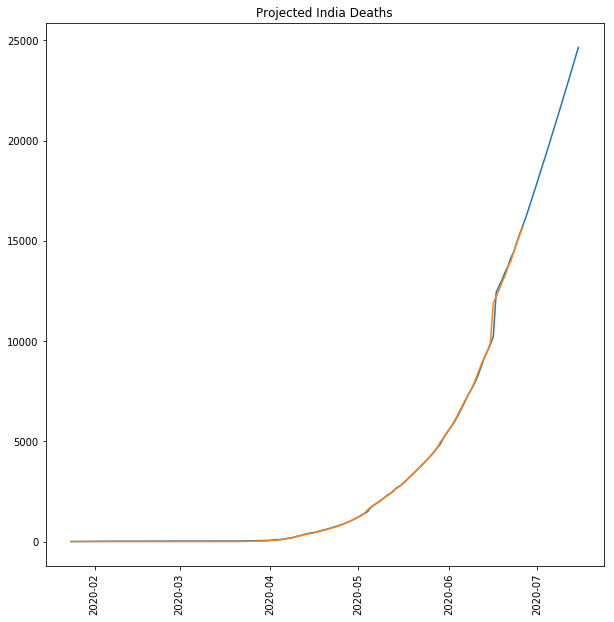

In [242]:
actual = df_deaths_ind.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.title('Projected India Deaths')
plt.show()

In [243]:
df_new = pd.DataFrame(actual)

In [244]:
df_new['predicted'] = ser2

In [245]:
df_new = df_new.rename(columns={"India":"actual"})

In [246]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [247]:
df_new.tail()

Country/Region,actual,predicted,error
2020-06-22,14011,14164.646956,153.646956
2020-06-23,14476,14460.631325,15.368675
2020-06-24,14894,14930.521056,36.521056
2020-06-25,15301,15346.992602,45.992602
2020-06-26,15685,15751.292622,66.292622


In [248]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [249]:
sum(df_new.error_squared) / len(df_new)

19821.963148793373

In [250]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

140.79049381543263

In [251]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [252]:
root_mean_square_error

140.79049381543263

### Forecast India's Active Cases

In [323]:
df_india_active = pd.DataFrame(df_trans.loc[:, 'India'])
df_india_active = df_india_active.rename({"India": 'Confirmed'}, axis='columns')

In [324]:
df_india_active['Recovered'] = df_trans_recovered.loc[:, 'India']

In [325]:
df_india_active['Active'] = df_india_active['Confirmed'] - df_india_active['Recovered']

In [327]:
df_india_active = df_india_active[['Active']]

In [328]:
df_temp = df_india_active
df_temp['exp'] = np.log10(df_india_active['Active'])

/home/akash/Dev/python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [330]:
df_temp = df_temp[df_temp.exp != -np.inf]

In [347]:
df_temp.tail()

,Active,exp
2020-06-22,192025,5.283358
2020-06-23,197498,5.295563
2020-06-24,201408,5.304077
2020-06-25,204764,5.311254
2020-06-26,213072,5.328526


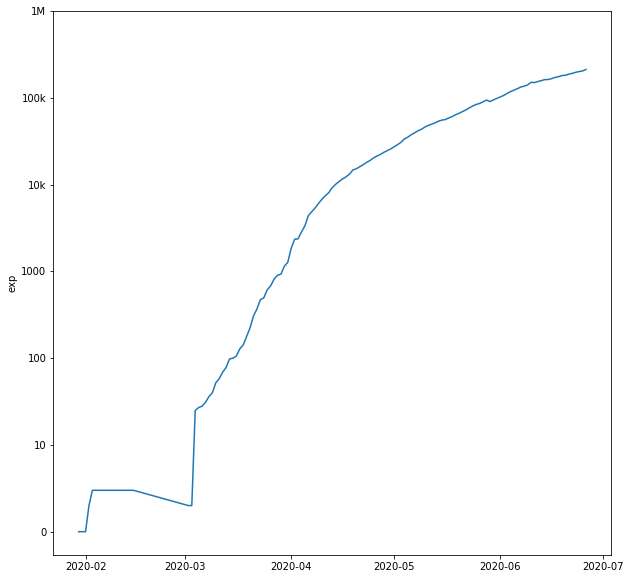

In [343]:
sns.lineplot(df_temp.index, df_temp.exp)
plt.yticks([0, 1, 2, 3, 4, 5, 6], ['0', '10', '100', '1000', '10k', '100k', '1M'])
plt.show()

In [308]:
# df_india_active = np.log(df_india_active)
# df_india_active = df_india_active[df_india_active != -np.inf]
df_india_active.tail()

2020-06-22    12.165381
2020-06-23    12.193484
2020-06-24    12.213088
2020-06-25    12.229613
2020-06-26    12.269385
Name: Active, dtype: float64

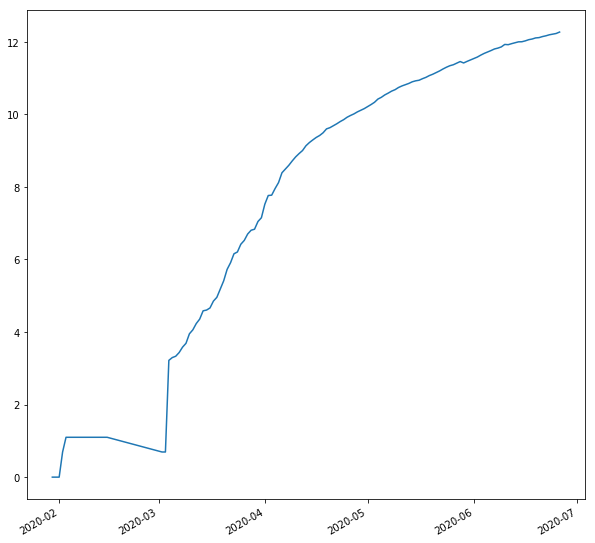

In [294]:
df_india_active.plot()

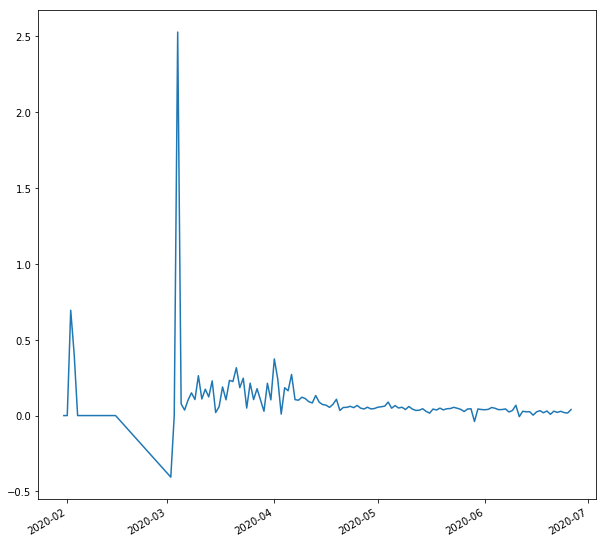

In [295]:
df_india_active.diff(periods=1).dropna().plot()

In [296]:
df_india_active_diff = df_india_active.diff(periods=1).dropna()

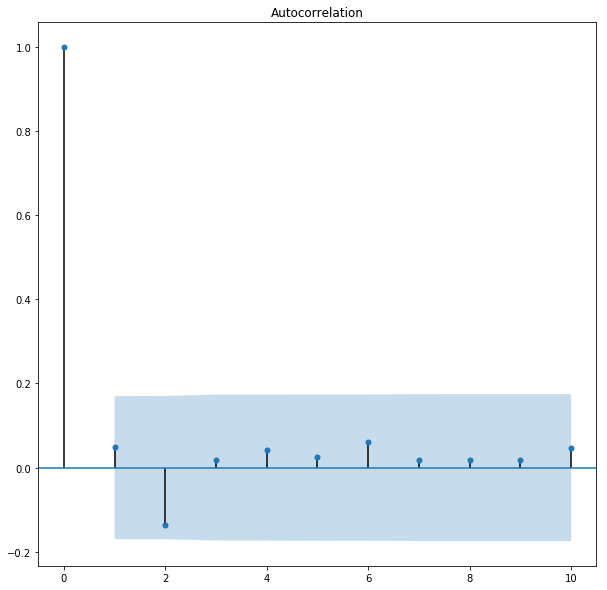

In [297]:
plot_acf(df_india_active_diff, lags=10)
plt.show()

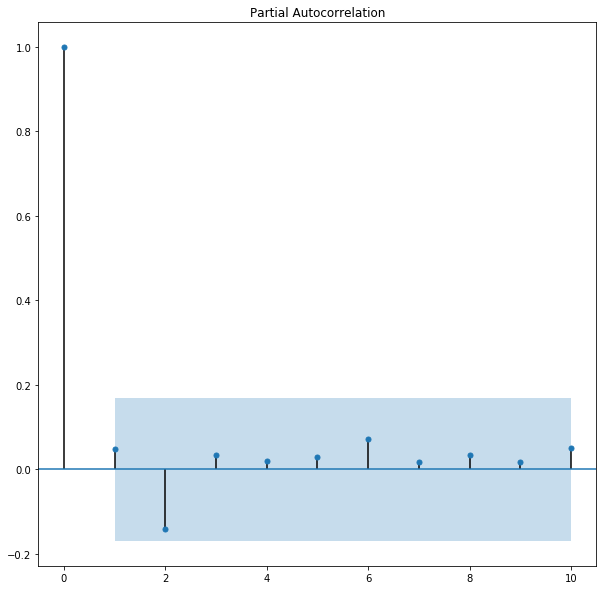

In [298]:
plot_pacf(df_india_active_diff, lags=10)
plt.show()

In [299]:
BIC = []
AIC = []
list_tup = []
for i in range(5):
    for j in range(5):
        try:
            ARIMA_model = ARIMA(df_india_active, order=(i, 1, j)).fit(transparams=False)
#             result = ARIMA_model.fit()
            BIC.append(ARIMA_model.bic)
            AIC.append(ARIMA_model.aic)
            print(f'i: {i} => j: {j}')
            t = tuple([i, j, ARIMA_model.aic, ARIMA_model.bic])
            list_tup.append(t)
        except Exception as e:
            print(e)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but 

i: 0 => j: 0
i: 0 => j: 1
i: 0 => j: 2
i: 0 => j: 3
i: 0 => j: 4
i: 1 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but 

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
i: 2 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but 

i: 2 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/

i: 2 => j: 2
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
i: 3 => j: 0
i: 3 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


i: 3 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/

i: 3 => j: 3
The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
i: 4 => j: 0


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


i: 4 => j: 1


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


i: 4 => j: 2


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


i: 4 => j: 3
i: 4 => j: 4


/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [300]:
list_tup

[(0, 0, -3.342081213267477, 2.4386170431760306),
 (0, 1, -1.7619000496462718, 6.909147335018989),
 (0, 2, -2.164963113153078, 9.396433399733937),
 (0, 3, -0.20305346843309735, 14.248692172675671),
 (0, 4, 1.374520401519078, 18.7166151708496),
 (1, 0, -1.645111739070387, 7.025935645594874),
 (2, 0, -2.242698726514618, 9.318697786372397),
 (2, 1, -0.35432209103930745, 14.097423550069461),
 (2, 2, 4.463496466717686, 21.80559123604821),
 (3, 0, -0.3884686901515124, 14.063276950957256),
 (3, 1, -0.8643633439555174, 16.477731425375005),
 (3, 2, 1.0382801800057564, 21.27072407755803),
 (3, 3, 3.989895235866811, 27.11268826164084),
 (4, 0, 1.548691912900324, 18.890786682230846),
 (4, 1, 2.06757665547849, 22.300020553030762),
 (4, 2, 27.305346709881178, 50.42813973565521),
 (4, 3, 13.335521849550673, 39.34866400354646),
 (4, 4, 15.087288477743584, 43.99077975996112)]

In [301]:
list_tup[0][3]

2.4386170431760306

In [302]:
def get_best_ar_ma_value(list_of_tup):
    least_bic = list_tup[0][3]
    best_params = list_tup[0]
    list_of_best_params = []
    for tup in list_of_tup:
        if tup[3] < least_bic:
            best_params = tup
            least_bic = tup[3]
    return best_params

In [303]:
get_best_ar_ma_value(list_tup)

(0, 0, -3.342081213267477, 2.4386170431760306)

In [304]:
ar, ma, aic, bic = get_best_ar_ma_value(list_tup)

In [305]:
ARIMA_model = ARIMA(df_india_active, order=(2, 1, 2)).fit(transparams=False)

/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/akash/Dev/python/venv/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [306]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Active   No. Observations:                  133
Model:                 ARIMA(2, 1, 2)   Log Likelihood                   3.768
Method:                       css-mle   S.D. of innovations                nan
Date:                Sun, 28 Jun 2020   AIC                              4.463
Time:                        18:19:20   BIC                             21.806
Sample:                             1   HQIC                            11.511
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1009      0.021      4.897      0.000       0.061       0.141
ar.L1.D.Active    -0.7969      0.061    -13.141      0.000      -0.916      -0.678
ar.L2.D.Active    -0.9642      0.036    -26.664      0.000      -1.035      -0.893
ma.L1.D.Active     0.8423        nan        nan        nan         nan         nan
ma.L2.D.Active     0.9589      0.056     17.256      0.000       0.850       1.068
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4132           -0.9308j            1.0184           -0.3165
AR.2           -0.4132           +0.9308j            1.0184            0.3165
MA.1           -0.4392           -0.9219j            1.0212           -0.3208
MA.2           -0.4392           +0.9219j            1.0212            0.3208
-----------------------------------------------------------------------------
"""

In [307]:
ARIMA_model.predict('2020-02-24', '2020-07-15', typ='levels')

KeyError: "invalid literal for int() with base 10: '2020-02-24'"

In [ ]:
arma_predict2 = ARIMA_model.predict('2020-03-24', '2020-07-15', typ='levels')
ser2 = arma_predict2

### Mean Absolute Error for Forecast Evaluation

In [ ]:
actual = df_india_active.loc['2020-01-24':]

In [ ]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
df_new = pd.DataFrame(actual)

In [ ]:
df_new['predicted'] = ser2

In [ ]:
df_new.head()

In [ ]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.Active)

In [ ]:
df_new.tail()

In [ ]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.Active)

In [ ]:
sum(df_new.error_squared) / len(df_new)

In [ ]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error

In [ ]:
ser2

### Forecast India's Confirmed Cases

### India Confirmed Cases

In [ ]:
df_trans_confirmed_ind = df_trans[['India']]
plt.plot(df_trans_confirmed_ind)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind1 = df_trans_confirmed_ind.diff().fillna(df_trans_confirmed_ind)
df_ind1.tail()

In [ ]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plot_acf(df_ind2)
plt.show()

In [ ]:
plot_pacf(df_ind2)
plt.show()

In [ ]:
for i in range(10):
    for j in range(10):
        try:
            ARIMA_model = ARIMA(df_trans_deaths_ind, order=(i, 2, j)).fit(transparams=False)
            print(f"i: {i} => j: {j}")
        except Exception as e:
            pass
#             print(f"Error -> i: {i} => j: {j}")

In [ ]:
ARIMA_model = ARIMA(df_trans_confirmed_ind, order=(2, 2, 2)).fit(transparams=False)

In [ ]:
ARIMA_model.summary()

In [ ]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-07-15', typ='levels')

In [ ]:
arma_predict

In [ ]:
undiff1 = df_ind2.cumsum().fillna(df_ind2)
undiff2 = df_ind1.cumsum().fillna(df_ind1)

### Mean Absolute Error for Forecast Evaluation

In [ ]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-08-15', typ='levels')
ser2 = arma_predict2

In [ ]:
ser2.diff()

### Note:

- The model predicted number of deaths on 13th June as 648.
- Actual number of deaths on 13th June: 654

In [ ]:
actual = df_trans_confirmed_ind.loc['2020-01-24':, :]
plt.plot(ser2)
plt.plot(actual)
plt.xticks(rotation=90)
plt.title('Projected India Confirmed Cases')
plt.show()

### Converting DataFrame to actual time series data, where each day has number of deaths i.e deaths value is not cumulated.

In [ ]:
df_trans_deaths_us = df_trans_deaths[['US']]

In [ ]:
df_trans_deaths_us = df_trans_deaths_us.diff(axis=0).fillna(df_trans_deaths_us)

In [ ]:
df_trans_deaths_us.tail()

In [ ]:
df_trans_deaths_us.index

In [ ]:
plt.plot(df_trans_deaths_us)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

In [ ]:
plt.plot(df_us1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_us1 = df_trans_deaths_us.diff().fillna(df_trans_deaths_us)
df_us1.tail()

In [ ]:
df_us2 = df_us1.diff().fillna(df_us1)
df_us2.tail()

In [ ]:
df_us2 = df_us1.diff().fillna(df_us1)
plt.plot(df_us2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plot_acf(df_us2)
plt.show()

In [ ]:
plot_pacf(df_us2)
plt.show()

In [ ]:
ARIMA_model = ARIMA(df_trans_deaths_us, order=(9, 1, 6)).fit(transparams=False)

In [ ]:
ARIMA_model.summary()

In [ ]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-06-25', typ='levels')

In [ ]:
arma_predict

### Mean Absolute Error for Forecast Evaluation

In [ ]:
arma_predict2 = ARIMA_model.predict('2020-01-23', '2020-06-25', typ='levels')
ser2 = arma_predict2

In [ ]:
actual = df_trans_deaths_us.loc['2020-01-24':, :]

In [ ]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
df_new = pd.DataFrame(actual)

In [ ]:
df_new['predicted'] = ser2

In [ ]:
df_new = df_new.rename(columns={"US":"actual"})

In [ ]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [ ]:
df_new.tail()

In [ ]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [ ]:
sum(df_new.error_squared) / len(df_new)

In [ ]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
test_results = adfuller(df_us2.US)

In [ ]:
test_results[1]

### India

### Converting DataFrame to actual time series data, where each day has number of deaths i.e deaths value is not cumulated.

In [ ]:
df_trans_deaths_ind = df_trans_deaths[['India']]

In [ ]:
df_trans_deaths_ind.head()

In [ ]:
df_trans_deaths_ind = df_trans_deaths_ind.diff(axis=0).fillna(df_trans_deaths_ind)

In [ ]:
df_trans_deaths_ind.tail()

In [ ]:
df_trans_deaths_ind.index

In [ ]:
plt.plot(df_trans_deaths_ind)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind1 = df_trans_deaths_ind.diff().fillna(df_trans_deaths_ind)
df_ind1.tail()

In [ ]:
plt.plot(df_ind1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
df_ind2.tail()

In [ ]:
df_ind2 = df_ind1.diff().fillna(df_ind1)
plt.plot(df_ind2)
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_ind2

In [ ]:
plot_acf(df_ind2)
plt.show()

In [ ]:
plot_pacf(df_ind2)
plt.show()

In [ ]:
list_tup = []
for i in range(10):
    for j in range(10):
        try:
            ARIMA_model = ARIMA(df_ind2, order=(i, 2, j)).fit(transparams=False)
            print(f'i: {i} => j: {j}')
            t = tuple([i, j])
            list_tup.append(t)
        except Exception as e:
            pass

In [ ]:
list_tup

In [ ]:
ARIMA_model = ARIMA(df_trans_deaths_ind, order=(2, 2, 4)).fit(transparams=False)

In [ ]:
ARIMA_model.summary()

In [ ]:
arma_predict = ARIMA_model.predict('2020-06-05', '2020-06-25', typ='levels')

In [ ]:
arma_predict

### Mean Absolute Error for Forecast Evaluation

In [ ]:
arma_predict2 = ARIMA_model.predict('2020-01-24', '2020-06-25', typ='levels')
ser2 = arma_predict2

In [ ]:
actual = df_trans_deaths_ind.loc['2020-01-24':, :]

In [ ]:
plt.plot(ser2, label='Predicted')
plt.plot(actual, label='Actual')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
df_new = pd.DataFrame(actual)

In [ ]:
df_new['predicted'] = ser2

In [ ]:
df_new = df_new.rename(columns={"India":"actual"})

In [ ]:
df_new.loc[:, 'error'] = np.absolute(df_new.predicted - df_new.actual)

In [ ]:
df_new.tail()

In [ ]:
df_new.loc[:, 'error_squared'] = np.square(df_new.predicted - df_new.actual)

In [ ]:
sum(df_new.error_squared) / len(df_new)

In [ ]:
np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error = np.sqrt(sum(df_new.error_squared) / len(df_new))

In [ ]:
root_mean_square_error

### Fitting Exponential Distribution

In [348]:
from scipy.stats import expon

In [349]:
mean, var, skew, kurt = expon.stats(moments='mvsk')

AttributeError: 'NoneType' object has no attribute 'update'

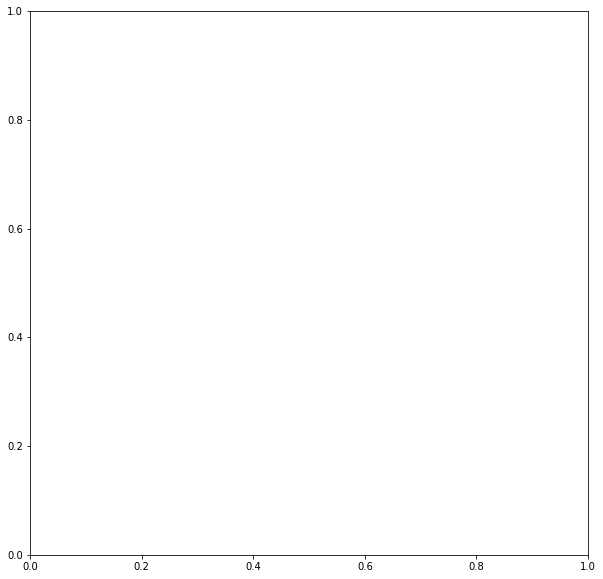

In [364]:
plt.hist([0, 1, 2, 3, 4, 5, 6], expon.pdf(df_temp.Active), 'r-', lw=5, alpha=0.6, label='expon pdf')

In [ ]:
rv = ex